# Building the Construction Activities Dictionary (NLP)
By: Chua Wen Soong (18032573)

Hi all, this project uses three word embedding techniques (Word2Vec, Word2Vec with Gensim Phrases, FastText) on a Construction corpus consisting of 50347 lines of short text). At the end, I have built a prototype semi-automatic evaluator that evaluates how effective are the different word embedding techniques in classifying words based on the user's intention.

Articles/Sourcecode referenced \
https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#training-your-own-model \
https://radimrehurek.com/gensim/models/keyedvectors.html \
https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92 \
https://towardsdatascience.com/word2vec-for-phrases-learning-embeddings-for-more-than-one-word-727b6cf723cf \
https://www.analyticsvidhya.com/blog/2020/08/information-retrieval-using-word2vec-based-vector-space-model/#:~:text=End%20Notes-,What%20is%20Information%20Retrieval%3F,in%20the%20information%20retrieval%20system. \
http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XEjbvM9KjJw \
https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72 \
http://kavita-ganesan.com/how-to-incorporate-phrases-into-word2vec-a-text-mining-approach/#.WuiiKtMvyds \
https://github.com/Suji04/NormalizedNerd/tree/master/Introduction%20to%20NLP \
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html \
https://towardsdatascience.com/visualizing-word-embedding-with-pca-and-t-sne-961a692509f5 \
https://github.com/marcellusruben/Word_Embedding_Visualization \
https://radimrehurek.com/gensim/models/phrases.html \
https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

# 1. Setting up the environment

In [71]:
# using Python version 3.8.5
from platform import python_version
python_version()

'3.7.12'

In [72]:
# installing packages
!pip install sklearn
!pip install nltk
!pip install gensim
!pip install numpy
!pip install --upgrade gensim

In [73]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [74]:
# importing main packages
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import gensim
import nltk

# import for shorthand / specific uses
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models.phrases import Phrases, Phraser
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics

# import graphics
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt

## wordnet corpus to be downloaded for lemmatization
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 2. Data Ingestion and Preprocessing

In [75]:
# Data Ingestion with Pandas
xls = pd.ExcelFile('/content/drive/MyDrive/Capstone/Dataset/ProjectsData.xlsx')

df1 = pd.read_excel(xls, 'Parcel F')
df2 = pd.read_excel(xls, 'SIS')
df3 = pd.read_excel(xls, 'LRT3')
df4 = pd.read_excel(xls, 'Belfield')
df5 = pd.read_excel(xls, 'CP2')
df6 = pd.read_excel(xls, 'TNB')
df7 = pd.read_excel(xls, 'PNLC')
df8 = pd.read_excel(xls, 'SMC4')

frames =[df1,df2,df3,df4,df5,df6,df7,df8]

data = pd.concat(frames)
data = data['task_name']
data

0       F2 BIM Development - Level 6
1                    F2 CA - Level 5
2                    F2 CA - Level 7
3                    F2 FM - Level 3
4                    F2 FM - Level 8
                    ...             
3867      Slab & Column L8 : Zone 1a
3868      Slab & Column L9 : Zone 1a
3869     Slab & Column L10 : Zone 1a
3870     Slab & Column L11 : Zone 1a
3871    Slab & Column Roof : Zone 1a
Name: task_name, Length: 50347, dtype: object

In [76]:
# removing punctuation with pandas(str.replace) and regex
data_nopunc = data
data_nopunc = data_nopunc.str.replace('[^\w\s]',' ')

# filling all nan values with blanks
data_nopunc = data_nopunc.fillna('')

# removing all standalone numbers
def no_nums(col):
    return ' '.join(filter(lambda word:word.replace('.','').isdigit()==False, col.split()))

data_nopunc = data_nopunc.apply(no_nums)
data_nopunc

0       F2 BIM Development Level
1                    F2 CA Level
2                    F2 CA Level
3                    F2 FM Level
4                    F2 FM Level
                  ...           
3867      Slab Column L8 Zone 1a
3868      Slab Column L9 Zone 1a
3869     Slab Column L10 Zone 1a
3870     Slab Column L11 Zone 1a
3871    Slab Column Roof Zone 1a
Name: task_name, Length: 50347, dtype: object

In [77]:
# corpus description
length_of_the_messages = data_nopunc.str.split("\\s+")

print(length_of_the_messages)
print("Max number of words = ", length_of_the_messages.str.len().max())
print("Index = ", length_of_the_messages.str.len().idxmax())
print("Min number of words = ", length_of_the_messages.str.len().min())
print("Index = ", length_of_the_messages.str.len().idxmin())


# maximum of number of words = 15
# minimum number of words = 1
# number of documents = 50347

0        [F2, BIM, Development, Level]
1                      [F2, CA, Level]
2                      [F2, CA, Level]
3                      [F2, FM, Level]
4                      [F2, FM, Level]
                     ...              
3867      [Slab, Column, L8, Zone, 1a]
3868      [Slab, Column, L9, Zone, 1a]
3869     [Slab, Column, L10, Zone, 1a]
3870     [Slab, Column, L11, Zone, 1a]
3871    [Slab, Column, Roof, Zone, 1a]
Name: task_name, Length: 50347, dtype: object
Max number of words =  15
Index =  543
Min number of words =  1
Index =  1231


In [78]:
# function to lowercase the words
def lowercasing(text):
    '''a function for lowercasing'''
    text = [word.lower() for word in text.split()]
    # joining the list of words with space separator
    return " ".join(text)

# lowercase the words
data_lower = data_nopunc
data_lower = data_lower.apply(lowercasing)
data_lower.head(20)



0             f2 bim development level
1                          f2 ca level
2                          f2 ca level
3                          f2 fm level
4                          f2 fm level
5               f2 l02 dd review archi
6               f2 l03 dd review archi
7             f2 bim development level
8             f2 bim development level
9             f2 bim development level
10            f2 l05 dd approval archi
11    f2 l07 dd submission batch archi
12            f2 l07 dd approval archi
13            f2 l08 dd approval archi
14                         f2 ca level
15                         f2 ca level
16                         f2 ca level
17                         f2 fm level
18                         f2 fm level
19                         f2 fm level
Name: task_name, dtype: object

In [79]:
# function for lemmatization (using wordnet)
lemmatizer = WordNetLemmatizer()

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

# lemmatizing the text
data_lemmatize = data_lower
data_lemmatize = data_lemmatize.apply(lemmatize_text)
data_lemmatize = data_lemmatize.str.join(' ')
data_lemmatize.head(20)

0             f2 bim development level
1                          f2 ca level
2                          f2 ca level
3                          f2 fm level
4                          f2 fm level
5               f2 l02 dd review archi
6               f2 l03 dd review archi
7             f2 bim development level
8             f2 bim development level
9             f2 bim development level
10            f2 l05 dd approval archi
11    f2 l07 dd submission batch archi
12            f2 l07 dd approval archi
13            f2 l08 dd approval archi
14                         f2 ca level
15                         f2 ca level
16                         f2 ca level
17                         f2 fm level
18                         f2 fm level
19                         f2 fm level
Name: task_name, dtype: object

In [80]:
# converting to list of lists via tokenization for preparation of word2vec
data_num = data_lemmatize
listing_num = data_num.tolist()
tokens_num = [word_tokenize(i) for i in listing_num]
tokens_num

[['f2', 'bim', 'development', 'level'],
 ['f2', 'ca', 'level'],
 ['f2', 'ca', 'level'],
 ['f2', 'fm', 'level'],
 ['f2', 'fm', 'level'],
 ['f2', 'l02', 'dd', 'review', 'archi'],
 ['f2', 'l03', 'dd', 'review', 'archi'],
 ['f2', 'bim', 'development', 'level'],
 ['f2', 'bim', 'development', 'level'],
 ['f2', 'bim', 'development', 'level'],
 ['f2', 'l05', 'dd', 'approval', 'archi'],
 ['f2', 'l07', 'dd', 'submission', 'batch', 'archi'],
 ['f2', 'l07', 'dd', 'approval', 'archi'],
 ['f2', 'l08', 'dd', 'approval', 'archi'],
 ['f2', 'ca', 'level'],
 ['f2', 'ca', 'level'],
 ['f2', 'ca', 'level'],
 ['f2', 'fm', 'level'],
 ['f2', 'fm', 'level'],
 ['f2', 'fm', 'level'],
 ['f2', 'fm', 'level'],
 ['f2', 'bim', 'development', 'level'],
 ['f2', 'l04', 'dd', 'approval', 'archi'],
 ['f2', 'l05', 'dd', 'preparation', 'archi'],
 ['f2', 'l07', 'dd', 'preparation', 'archi'],
 ['f2', 'l04', 'dd', 'review', 'id'],
 ['f2', 'l06', 'dd', 'review', 'id'],
 ['f2', 'l08', 'dd', 'preparation', 'id'],
 ['f2', 'bim', 'd

In [81]:
# number of tokens
count = 0
for listElem in tokens_num:
    count += len(listElem)                    
print('Total Number of elements : ', count)

Total Number of elements :  256556


## Building the second Corpus

In [82]:
### corpus without numeric characters -> Corpus B = tokens_alpha
#Removing all non-alpha characters
data_clean = data_lemmatize
data_clean = data_clean.str.replace('[^A-z ]','').str.replace(' +',' ').str.strip()

#data without numbers
data_alpha = data_clean

# converting the data to list format
listing_alpha = data_alpha.tolist()

# tokenizing the data to prepare for word2vec modelling
tokens_alpha = [word_tokenize(i) for i in listing_alpha]


# 3. Training Word Embedding models

## Training Word2vec

In [83]:
# Training Word2Vec model
modelNum = gensim.models.Word2Vec(tokens_num, vector_size=200, sg=1, epochs=10)
modelAlp = gensim.models.Word2Vec(tokens_alpha, vector_size=200, sg=1, epochs=10)

In [84]:
# listing 30 vocabulary in Word2vec models
print("Word2vec Numeric Model First 30 Vocabulary")
for index, word in enumerate(modelNum.wv.index_to_key):
    if index == 30:
        print("\n")
        break
    print(f"modelNum word #{index}/{len(modelNum.wv.index_to_key)} is {word}")

print("Word2vec Alpha Model First 30 Vocabulary")
for index, word in enumerate(modelAlp.wv.index_to_key):
    if index == 30:
        break
    print(f"modelAlp word #{index}/{len(modelAlp.wv.index_to_key)} is {word}")

Word2vec Numeric Model First 30 Vocabulary
modelNum word #0/1752 is fix
modelNum word #1/1752 is 3rd
modelNum word #2/1752 is 2nd
modelNum word #3/1752 is c
modelNum word #4/1752 is 1st
modelNum word #5/1752 is rc
modelNum word #6/1752 is level
modelNum word #7/1752 is slab
modelNum word #8/1752 is zone
modelNum word #9/1752 is fitting
modelNum word #10/1752 is ar
modelNum word #11/1752 is plumbing
modelNum word #12/1752 is system
modelNum word #13/1752 is conduit
modelNum word #14/1752 is a
modelNum word #15/1752 is bs
modelNum word #16/1752 is electrical
modelNum word #17/1752 is column
modelNum word #18/1752 is l01
modelNum word #19/1752 is room
modelNum word #20/1752 is fire
modelNum word #21/1752 is s
modelNum word #22/1752 is me
modelNum word #23/1752 is l03
modelNum word #24/1752 is floor
modelNum word #25/1752 is door
modelNum word #26/1752 is l02
modelNum word #27/1752 is work
modelNum word #28/1752 is wall
modelNum word #29/1752 is water


Word2vec Alpha Model First 30 Vocabu

In [85]:
#Checking vocabulary index and sizes
fitting_idx = modelNum.wv.key_to_index["fitting"]
fitting_cnt = modelNum.wv.get_vecattr("fitting", "count")
print('Vocabulary size:', len(modelNum.wv))
print('Fitting:', fitting_idx, fitting_cnt)

# Vocabulary size of the corpus is 1752
# the word 'fitting' is in index 9 and has 2798 occurrences

Vocabulary size: 1752
Fitting: 9 2798


In [86]:
# word2vec vector representation of the word 'fitting'
vec_fitting = modelNum.wv['fitting']
vec_fitting

array([ 7.04520404e-01, -2.92542100e-01, -2.87430644e-01, -2.27834538e-01,
        3.71109575e-01, -5.47106683e-01,  6.09308898e-01,  5.18856406e-01,
       -1.69759437e-01,  5.37321270e-01,  9.46948752e-02, -2.45846078e-01,
       -2.11814493e-02,  6.97737396e-01, -1.06616497e-01, -2.29819983e-01,
        1.24001712e-01,  4.29958045e-01,  1.45951211e-01, -4.24512386e-01,
       -6.26711309e-01, -1.95370913e-01, -6.87025726e-01, -3.06858569e-01,
       -1.69417471e-01,  4.92741495e-01, -9.82887149e-01, -3.64077874e-02,
       -3.22129428e-01, -2.62611732e-02,  7.08771288e-01,  8.76131654e-02,
        2.20909715e-01,  1.06354147e-01, -2.73495883e-01, -9.55415070e-02,
        7.76333272e-01,  7.11408615e-01,  7.01564625e-02, -2.92085055e-02,
       -4.18457419e-01, -3.61347347e-01,  3.21465105e-01,  5.21744937e-02,
        2.45993778e-01, -4.39465463e-01,  1.08097315e-01,  1.17351236e-02,
        5.67888498e-01, -2.36621410e-01, -3.95385832e-01,  4.66520280e-01,
        9.69393924e-02,  

In [127]:
# seeing word similarity between two words
modelNum.wv.similarity('drawing','filling')

KeyError: ignored

In [88]:
# top n closest words to w1
w1='ca'
modelNum.wv.most_similar (positive=w1, topn=20)

[('cav', 0.9231466054916382),
 ('date', 0.9140104055404663),
 ('certificate', 0.9117743968963623),
 ('ccc', 0.9102696776390076),
 ('availability', 0.9008682370185852),
 ('target', 0.8945319056510925),
 ('section', 0.8149111866950989),
 ('compliance', 0.8091428875923157),
 ('snaglist', 0.8084522485733032),
 ('acceptance', 0.8009750843048096),
 ('cleaning', 0.8008140325546265),
 ('movement', 0.7993316054344177),
 ('cpc', 0.7872751951217651),
 ('letter', 0.7794190049171448),
 ('overall', 0.7787727117538452),
 ('parcel', 0.773737907409668),
 ('cxs', 0.7704567313194275),
 ('confimration', 0.7671160101890564),
 ('gs07', 0.7629145383834839),
 ('dismantle', 0.7580377459526062)]

## Using Word2vec with Phraser

In [89]:
### building the Phraser model for both corpora
# gensim Phraser model is built to handle bigrams and trigrams
def build_phrases(sentences):
    phrases = Phrases(sentences,
                      min_count=5,
                      threshold=5,
                      progress_per=1000,
                      connector_words=ENGLISH_CONNECTOR_WORDS)
    return Phraser(phrases)

phrasesNum=build_phrases(tokens_num)
phrasesAlp=build_phrases(tokens_alpha)

In [90]:
# list the phrases and their scores
for phrase, score in phrasesNum.find_phrases(tokens_num).items():
    print(phrase, score)

bim_development 25.979428721174003
dd_review 20.340711805555554
dd_approval 7.682642948141487
dd_submission 8.262184679239201
dd_preparation 14.3340586549217
sh_approval 7.214925389065602
sh_review 19.102373887240354
sh_preparation 13.461404417182802
sh_submission 7.759184751103433
cn_preparation 49.14534395973154
f2_abortive 5.487062404870625
branch_duct 8.57092654722911
fire_protection 9.12216166451565
branch_pipe 11.562888208434952
demountable_wall 11.121648565731817
commencement_of_fft 5.504122366265997
electrical_fft 7.389909745162813
signing_by_pbsb 100.13888888888889
electrical_pa 8.542695724326435
walk_through 250.3472222222222
end_user 616.2393162393163
commencement_of_id 5.296174413821473
mock_up 83.2706369947995
preparation_amendment 5.040548098434004
3d_perspective 77.02991452991454
f3l05_sh 20.057492581602375
f3_abortive 6.808309726156751
testing_commissioning 41.21996124031008
commencement_of_architecture 15.147058823529413
completion_of_architecture 6.5688775510204085
fl

In [ ]:
# Training Word2Vec model with phrases
modelNum_phrases = gensim.models.Word2Vec(phrasesNum[tokens_num], vector_size=200, sg=1, epochs=10)
modelAlp_phrases = gensim.models.Word2Vec(phrasesAlp[tokens_alpha], vector_size=200, sg=1, epochs=10)

In [92]:
# example word "bim_development"
w1='bim_development'
modelNum_phrases.wv.most_similar (positive=w1, topn=20)

[('ca', 0.9902515411376953),
 ('gdc_bracket', 0.8560610413551331),
 ('hydrant_bracket', 0.8541300296783447),
 ('procurement_transformer', 0.8505315184593201),
 ('submittal_architecture', 0.8319750428199768),
 ('earthing', 0.8245694041252136),
 ('architecture_ga', 0.8153259754180908),
 ('lightning_protection', 0.8137725591659546),
 ('fm', 0.7953318953514099),
 ('tray_bracket', 0.7922877073287964),
 ('walk_through', 0.7827953100204468),
 ('bomba_inspection', 0.7770419716835022),
 ('commencement_of_id', 0.773492157459259),
 ('procurement_photo', 0.7712388634681702),
 ('brickwork_blockworks', 0.7697125673294067),
 ('glass_subframe', 0.7666239142417908),
 ('telekom_cable', 0.761536717414856),
 ('tray_ladder', 0.7591149210929871),
 ('voltaic', 0.7591003775596619),
 ('vinyl_floor', 0.7590432167053223)]

## Training FastText Model

In [128]:
# FastText embedding
from gensim.models import FastText
modelNum_fasttext = FastText(tokens_num, vector_size=200, window=3, sg=1, epochs=10)
modelAlp_fasttext = FastText(tokens_alpha, vector_size=200, window=3, sg=1, epochs=10)

In [131]:
# typos are also detected with fast text model, would be good for similar words in malay
# casting, kasting = 0.9236939
# bondek, bondeck = 0.9480202
print(modelNum_fasttext.wv.similarity('casting','kasting'))

modelNum_fasttext.wv.similarity('bondek','bondeck')

0.9177703


0.9424355

In [130]:
# fasttext also works on words foreign to the corpus
# as an example, 'no_such_word' returns false as it is not in the corpus it was trained on
print("no_such_word" in modelNum_fasttext.wv.key_to_index)

# the Fast Text model can still represent it as a vector
modelNum_fasttext.wv["no_such_word"]

False


array([ 0.06451366, -0.02561819, -0.0861996 , -0.04600014, -0.00212554,
       -0.015801  ,  0.02591274, -0.01529857, -0.05096483,  0.01618957,
       -0.03849858, -0.02375366, -0.04593437,  0.02066607, -0.0358818 ,
       -0.06216817,  0.02979867, -0.02089084, -0.00595867, -0.01233199,
       -0.03626912, -0.01681665, -0.10913582, -0.03365823,  0.01557543,
        0.02892808, -0.03593939,  0.00770705, -0.01642971,  0.03482245,
       -0.02834753,  0.0007461 , -0.02276677,  0.03620627, -0.05411963,
       -0.03326527,  0.07071134, -0.01796581, -0.00711484, -0.00848056,
        0.0336133 ,  0.02980288,  0.00963592, -0.04137032,  0.0631908 ,
       -0.02517398,  0.03594109, -0.02301569, -0.00670848, -0.00717519,
        0.03415892,  0.02151152,  0.02733424,  0.0429801 , -0.0001598 ,
       -0.01416495,  0.07529522,  0.01497552,  0.0160005 ,  0.02431383,
       -0.02545129, -0.00947076, -0.0345344 ,  0.03857639,  0.00389972,
        0.01826314,  0.01639025,  0.0081495 , -0.02299478,  0.02

# 4. Visualisation and K-means Clustering

## Visualising Functions below

In [96]:
# Function to append similar words to a list
def append_list(sim_words, words):
    
    list_of_words = []
    
    for i in range(len(sim_words)):
        
        sim_words_list = list(sim_words[i])
        sim_words_list.append(words)
        sim_words_tuple = tuple(sim_words_list)
        list_of_words.append(sim_words_tuple)
        
    return list_of_words

# Function to create a 2D TSNE scatterplot of similar words
def display_tsne_scatterplot_3D(model, user_input=None, words=None, label=None, color_map=None, perplexity = 0, learning_rate = 0, iteration = 0, topn=5, sample=10):

    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.wv ]
    
    word_vectors = np.array([model.wv[w] for w in words])
    
    two_dim = TSNE(n_components = 2, random_state=0, perplexity = perplexity, learning_rate = learning_rate, n_iter = iteration).fit_transform(word_vectors)[:,:2]
    #three_dim = TSNE(n_components = 3, random_state=0, perplexity = perplexity, learning_rate = learning_rate, n_iter = iteration).fit_transform(word_vectors)[:,:3]


    # For 2D/3D change the n_dim variable into the following:
    # two_dim = TSNE(n_components = 2, random_state=0, perplexity = perplexity, learning_rate = learning_rate, n_iter = iteration).fit_transform(word_vectors)[:,:2]
    # three_dim = TSNE(n_components = 3, random_state=0, perplexity = perplexity, learning_rate = learning_rate, n_iter = iteration).fit_transform(word_vectors)[:,:3]

    data = []


    count = 0
    for i in range (len(user_input)):

                trace = go.Scatter(
                    x = two_dim[count:count+topn,0], 
                    y = two_dim[count:count+topn,1],  
                    #z = two_dim[count:count+topn,2],
                    text = words[count:count+topn],
                    name = user_input[i],
                    textposition = "top center",
                    textfont_size = 10,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 0.8,
                        'color': 2
                    }
       
                )
                
                # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable. 
                # For 3D, instead of using go.Scatter, we need to use go.Scatter3d and add the z variable. 
                # Also, instead of using variable n_dim, use the variable that we have declared earlier (e.g two_dim/three_dim)
            
                data.append(trace)
                count = count+topn

    trace_input = go.Scatter(
                    x = two_dim[count:,0], 
                    y = two_dim[count:,1],  
                    #z = two_dim[count:,2],
                    text = words[count:],
                    name = 'input words',
                    textposition = "top center",
                    textfont_size = 10,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 1,
                        'color': 'black'
                    }
                    )

    # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable
    # For 3D, instead of using go.Scatter, we need to use go.Scatter3d and add the z variable.
    # Also, change the variable n_dim to use the variable that we have declared earlier (e.g two_dim/three_dim)
            
    data.append(trace_input)
    
# Configure the layout

    layout = go.Layout(
        margin = {'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
        legend=dict(
        x=1,
        y=0.5,
        font=dict(
            family="Courier New",
            size=15,
            color="black"
        )),
        font = dict(
            family = " Courier New ",
            size = 10),
        autosize = False,
        width = 1000,
        height = 1000
        )


    plot_figure = go.Figure(data = data, layout = layout)
    plot_figure.show()

    
# function for visualising top 5 closest words to user input
def model_sim_words(model):
    for words in user_input:

            sim_words = model.wv.most_similar(words, topn = 5)
            sim_words = append_list(sim_words, words)

            result_word.extend(sim_words)

    similar_word = [word[0] for word in result_word]
    similarity = [word[1] for word in result_word] 
    similar_word.extend(user_input)
    labels = [word[2] for word in result_word]
    label_dict = dict([(y,x+1) for x,y in enumerate(set(labels))])
    color_map = [label_dict[x] for x in labels]

    display_tsne_scatterplot_3D(model, user_input, similar_word, labels, color_map, 5, 500, 10000)
    


## Visualisation of the models and their similar words

In [97]:
##example
# visualisation for word2vec numeric model
# input string in input_word
# multiple words are delimited with a comma
input_word = 'casting, drawing, f, level, b2, f3, l1, swimming, hacking, jalan, kawasan'
user_input = [x.strip() for x in input_word.split(',')]
result_word = []

print('modelNum similar words graph')
print("Vocabulary used:", input_word)
model_sim_words(modelNum)

# visualisation for word2vec alpha model, numbers are removed
input_word = 'casting, drawing, f, level, b, l, swimming, hacking, jalan, kawasan'
user_input = [x.strip() for x in input_word.split(',')]
result_word = []

print('modelAlp similar words graph')
print("Vocabulary used:", input_word)
model_sim_words(modelAlp)

modelNum similar words graph
Vocabulary used: casting, drawing, f, level, b2, f3, l1, swimming, hacking, jalan, kawasan


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



modelAlp similar words graph
Vocabulary used: casting, drawing, f, level, b, l, swimming, hacking, jalan, kawasan


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



In [98]:
# swimming and kawasan are altered as they are out of vocabulary in word2vec
# visualisation for word2vec numeric phrases model
input_word = 'casting, drawing, f, level, b, f3, l1, swimming_pool, hacking, jalan, kawasan_station'
user_input = [x.strip() for x in input_word.split(',')]
result_word = []

print("modelNum_phrases similar words graph")
print("Vocabulary used:", input_word)
model_sim_words(modelNum_phrases)

# visualisation for word2vec alpha phrases model
input_word = 'casting, drawing, f, level, b, l, swimming_pool, hacking, jalan, kawasan_station'
user_input = [x.strip() for x in input_word.split(',')]
result_word = []

print("modelAlp_phrases similar words graph")
print("Vocabulary used:", input_word)
model_sim_words(modelAlp_phrases)

modelNum_phrases similar words graph
Vocabulary used: casting, drawing, f, level, b, f3, l1, swimming_pool, hacking, jalan, kawasan_station


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



modelAlp_phrases similar words graph
Vocabulary used: casting, drawing, f, level, b, l, swimming_pool, hacking, jalan, kawasan_station


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



In [99]:
# visualisation for fastText numeric model
input_word = 'castig, dawing, f, level, b2, f3, l1, swimming, hacking, jalan, kawasan'
user_input = [x.strip() for x in input_word.split(',')]
result_word = []

print("modelNum_fasttext similar words graph")
print("Vocabulary used:", input_word)
model_sim_words(modelNum_fasttext)

# visualisation for fastText alpha model
## able to input OOV words
input_word = 'castig, dawing, f, level, b2, f3, l1, swimming, hacking, jalan, kawasan'
user_input = [x.strip() for x in input_word.split(',')]
result_word = []

print("modelAlp_fasttext similar words graph")
print("Vocabulary used:", input_word)
model_sim_words(modelAlp_fasttext)

modelNum_fasttext similar words graph
Vocabulary used: castig, dawing, f, level, b2, f3, l1, swimming, hacking, jalan, kawasan


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



modelAlp_phrases similar words graph
Vocabulary used: castig, dawing, f, level, b2, f3, l1, swimming, hacking, jalan, kawasan


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



## Clustering with k-means

In [100]:
# function for reducing model dimensions using tsne
def tsne_transform(model):
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42)
    tsne_matrix = tsne_model.fit_transform(model.syn1neg)
    return tsne_matrix

modelNum_fasttext_tsne= tsne_transform(modelNum_fasttext)
modelNum_fasttext_tsne

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



array([[ 47.279194 , -53.882603 ],
       [ 47.351902 , -55.03623  ],
       [ 46.953846 , -56.52326  ],
       ...,
       [-11.220561 ,  10.204266 ],
       [ -4.7585177, -35.409    ],
       [ -7.8674526, -11.988617 ]], dtype=float32)

In [101]:
## using elbow plot to see reasonable number of clusters to use
# function for the elbow plot
def elbow_plot(model):
    model_tsne= tsne_transform(model)
    # fitting multiple k-means algorithms and storing the values in an empty list
    SSE = []
    for cluster in range(1,25):
        kmeans = KMeans(n_clusters = cluster, init='k-means++')
        kmeans.fit(model_tsne)
        SSE.append(kmeans.inertia_)

    # converting the results into a dataframe and plotting them
    frame = pd.DataFrame({'Cluster':range(1,25), 'SSE':SSE})
    plt.figure(figsize=(12,6))
    plt.plot(frame['Cluster'], frame['SSE'], marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')


Elbow Plot for FastText Corpus A


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



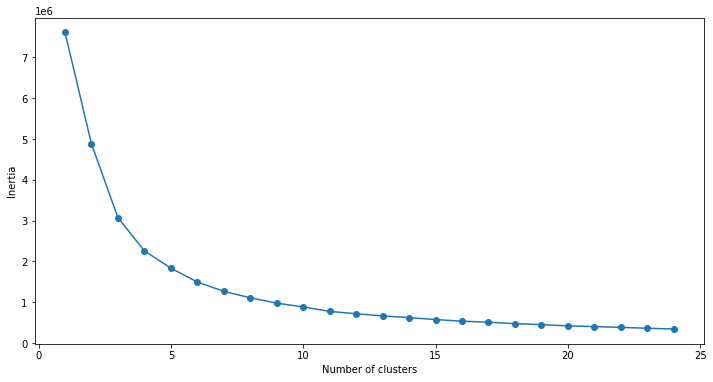

In [102]:
# elbow plot for FastText Corpus A
print("Elbow Plot for FastText Corpus A")
elbow_plot(modelNum_fasttext)
# optimal cluster is around 10

In [103]:
# using k-means to cluster the model
kmeans = KMeans(n_clusters = 10, init='k-means++')
kmeans.fit(modelNum_fasttext_tsne)
pred = kmeans.predict(modelNum_fasttext_tsne)

# computing the counts by using pandas function
frame = pd.DataFrame(modelNum_fasttext_tsne)
frame['cluster'] = pred
frame['cluster'].value_counts()


4    238
9    209
5    207
6    193
3    160
2    159
7    157
1    153
0    152
8    124
Name: cluster, dtype: int64

In [104]:
# function returns cluster indices
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

# function to convert cluster index to words from the trained model
def index_to_words(cluster_indices, model):
    cluster_words = map(lambda index: model.wv.index_to_key[index],cluster_indices)
    return cluster_words

In [105]:
# cluster list of words
clusterNum_fasttext_tsne = ClusterIndicesNumpy(0, frame)
cluster_words = index_to_words(clusterNum_fasttext_tsne,modelNum_fasttext)
print(list(cluster_words))


['c', 'rc', 's', 'formwork', 'rebar', 'casting', 'e', 'lw', 'core', 'g', 'ta', 'lggf', 'rw', 'retaining', 'b2b1', 'b1lg', 'f', 'lp', 'tb', 'az02', 'az01', 'j', 'bz02', 'h', 'bz01', 'td', 'lp1', 'alp1', 'cz02', 'cz01', 'gfl01', 'dz01', 'dz02', 'inner', 'x', 'blp2', 'lp2', 'mr', 'hlp1h', 'outer', 'clp3', 'lp3', 'l01l02', 'lp4', 'ez05', 'ez01', 'ez02', 'ez03', 'cz05', 'fz01', 'dlp4', 'gfm', 'bz04', 'bz05', 'dz05', 'gz01', 'ez06', 'ez04', 'dz04', 'cz04', 'dz06', 'az03', 'bz06', 'az04', 'jz01', 'az05', 'jz04', 'jz03', 'l02l03', 'l03l04', 'l04l05', 'l05l06', 'l06l07', 'cz06', 'l07l08', 'flp1f', 'jz02', 'gz03', 'gz04', 'gz02', 'cz03', 'hz03', 'hz02', 'hz01', 'fz03', 'fz02', 'elp1e', 'lp1f', 'lp1e', 'bz03', 'lp2j', 'rcw', 'alp1a', 'hz04', 'dz03', 'lp1j', 'clp3a', 'az06', 'l09l10', 'l08l09', 'elp2e', 'lp4a', 'lp2e', 'ml01', 'l02r', 'lp1h', 'elp3e', 'l10l11', 'l12l13', 'l11l12', 'lp3e', 'flp2f', 'dlp4a', 'lp1a', 'gz07', 'clp4a', '12nos', 'gz05', 'gz06', '9nos', 'lp2f', 'ez07', 'ez08', 'lp3a', 'j

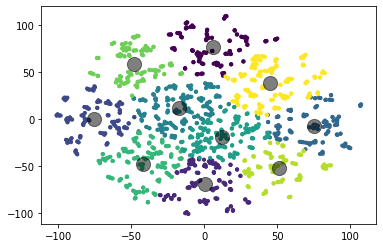

In [106]:
# visualisation of cluster plot
# Cluster with their centers shown as black dots
y_kmeans = kmeans.predict(modelNum_fasttext_tsne)
plt.scatter(modelNum_fasttext_tsne[:, 0], modelNum_fasttext_tsne[:, 1], c=y_kmeans, s=10, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=200, c='black', alpha=0.5);

## Clustering for the other models

In [107]:
# function for producing cluster plots
# model = model to use
# cluster_n = number of clusters
# cluster = specific cluster for its list of words
def kmeans_cluster_plot(model,cluster_n):
    # same clustering was done with other models
    model_tsne= tsne_transform(model)

    # using k-means to cluster
    kmeans = KMeans(n_clusters = cluster_n, init='k-means++')
    kmeans.fit(model_tsne)
    pred = kmeans.predict(model_tsne)
    y_kmeans = kmeans.predict(model_tsne)
    # computing the counts by using pandas function
    frame = pd.DataFrame(model_tsne)
    frame['cluster'] = pred
    frame['cluster'].value_counts()
    
    for x in range(cluster_n):
        cluster_tsne = ClusterIndicesNumpy(x, frame)
        cluster_word_list = index_to_words(cluster_tsne,model)
        print(list(cluster_word_list))
    
    # clusters with their centers shown as black dots
    plt.scatter(model_tsne[:, 0], model_tsne[:, 1], c=y_kmeans, s=10, cmap='viridis')
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], s=200, c='black', alpha=0.5);



## Elbow Plots

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



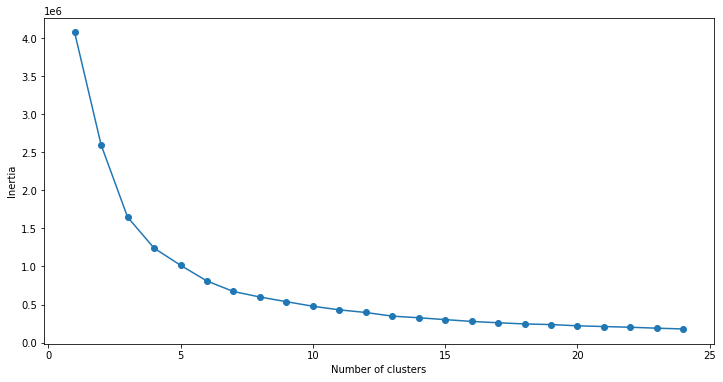

In [108]:
elbow_plot(modelAlp_fasttext)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



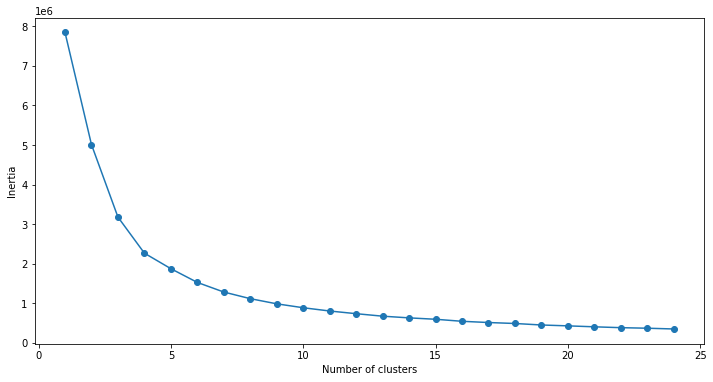

In [109]:
elbow_plot(modelNum)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



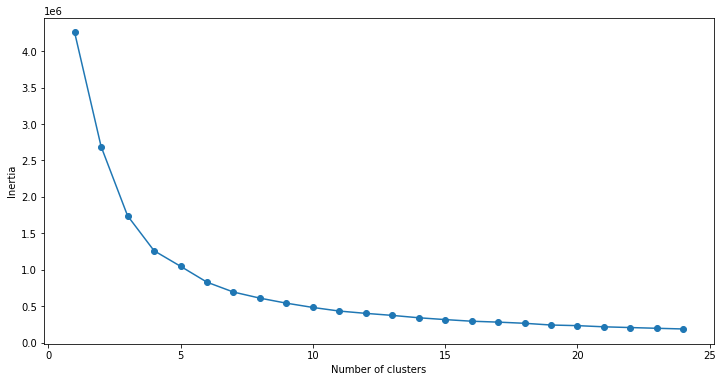

In [110]:
elbow_plot(modelAlp)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



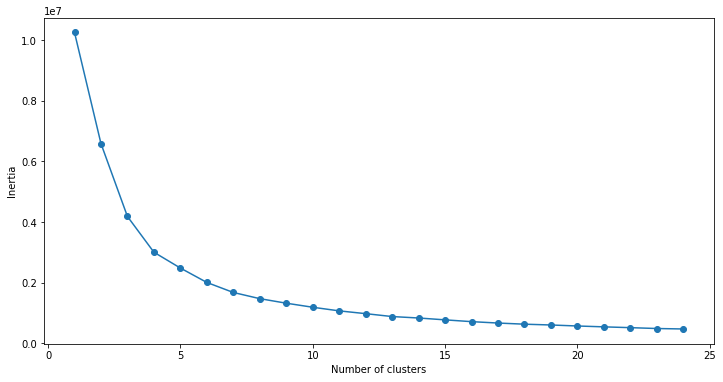

In [111]:
elbow_plot(modelNum_phrases)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



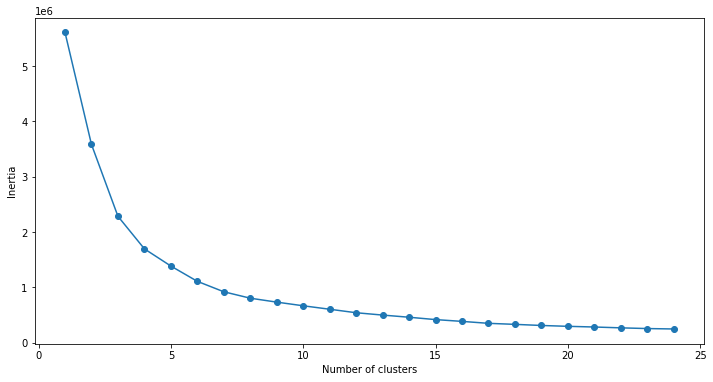

In [112]:
elbow_plot(modelAlp_phrases)

In [113]:
## Cluster word lists and plots

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



['to', 'relocation', 't1', 't3', 'fm', 'development', 'mobilisation', 'earthwork', 'all', 'foundation', 'rectification', 'treatment', 'segment', 'probing', 'rock', 'mapping', 'cavity', 'model', 'super', 'm50', 'piloting', 'm32', 'gl10', 'sec', 'opening', 'extension', 'consulting']
['a', 'b', 'signage', 'wt', 'ft', 'sc', 'r', 'sn', 'cp', 'aluminium', 'dr', 'bw', 'df', 'ir', 'glazing', 'al', 'wp', 'sf', 'studio', 'front', '1a', 'shutter', 'roller', 'wheel', '2a', 'a1a', 'coating', 'a2b', 'cladding', '1b', 'bc', 'hump', '6c', 'ba', 'stopper', 'bollard', 'expoxy', 'bb', 'screen', '7d', 'ms21', '3aa', 'ms22', 'ms23']
['approval', 'submission', 'shop', 'construction', 'built', 'panel', 'fw', 'tm', 'ready', 'control', 'wms', 'refuse', 'over', 'chamber', 'ww', 'handing', 'shopdrawing', 'perforated', 'pp', 'fan', 'ahu', 'fcu', 'roadwork', 'mansory', 'siphonic', 'bmu', 'mockup', 'surface', 'turf', 'artificial', 'petroleum', 'automation', 'ibms', 'liquefied', 'solar', 'sm', 'skyfold']
['lw', 'cor

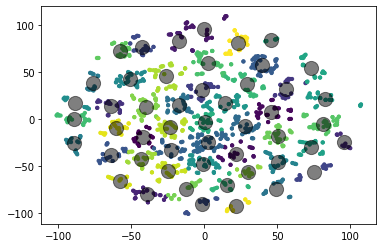

In [114]:
# clustering for modelNum_fasttext
kmeans_cluster_plot(modelNum_fasttext, 50)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



['signage', 'drawing', 'survey', 'supervision', 'fencing', 'signing', 'fee', 'receival', 'agreement', 'lpg', 'mobilisation', 'clearing', 'issuance', 'upon', 'setting', 'lake', 'dilapidation', 'out', 'lining', 'demarcation', 'clearance', 'posession', 'entry']
['cw', 'chilled', 'wt', 'ft', 'sn', 'ex', 'cb', 'osd', 'wp', 'sf', 'coating', 'stressing', 'col', 'slb', 'fwk', 'rbr', 'recticulation', 'expoxy', 'underpass', 'wl', 'pt', 'er', 'dainage', 'rslb', 'wr', 'sft']
['roof', 'bridge', 'ped', 'link', 'walkway', 'truss', 'covered', 'bp', 'do', 'foyer', 'aur', 'jack', 'pedestrian', 'app', 'louvre', 'iconic', 'permit', 'segment', 'decking', 'tactile', 'alumn', 'aerofoil', 'handrail', 'footing']
['level', 'me', 'elv', 'bm', 'dw', 'ductworks', 'awcs', 'lower', 'plumbling', 'mezz', 'mezzanine', 'jl', 'adb', 'fb', 'acb', 'eb', 'abb', 'aab', 'agf', 'cgf', 'dgf', 'bgf', 'hgf', 'ggf', 'gb', 'jgf', 'egf', 'fgf']
['water', 'sanitary', 'cold', 'hot', 'commissioning', 'pump', 'pre', 'coldwater', 'tank',

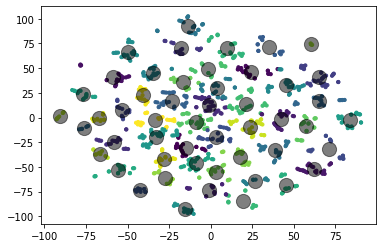

In [115]:
# clustering for modelAlp_fasttext
kmeans_cluster_plot(modelAlp_fasttext, 50)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



['commissioning', 'podium', 'testing', 'pit', 'cable', 'erection', 'passenger', 'crane', 'dismantle', 'overall', 'gdc', 'hoist', 'ladder', 'scaffolding', 'log', 'tray', 'telekom', 'hoisting', 'syabas', 'hydrant', 'sectional', 'counterweight', 'motor', 'cwp', 'landing', 'ph', 'inspected', 'tc5', 'tc1', 'tc4', 'tc3', 'tc6']
['door', 'frame', 'window', 'plastering', 'installation', 'ironmongery', 'brickwork', 'leaf', 'panel', 'brickwall', 'fw', 'glass', 'aluminium', 'ww', 'perforated', 'subframe', 'pp', 'louver', 'cladding', 'sliding', 'aluminum', 'pivot', 'solar', 'specialist', 'screen', 'skyfold', 'fr', 'partion']
['zone', 'the', 'spine', 'staircase', 'l1', 'gl', 'roof', 'g', 'l2', 'residential', 'villa', 'steel', 'sl', 'elt', 'liftcore', 'l3', 'l9', 'b4', 'encasement', 'bondek', 'l5', 'l6', 'l4', 'l7', 'l8', 'b12', 'a6', 'a5', 'a4', 'rf', 'b9', 'b11', 'b5', 'b6', 'b8', 'b10', 'b7', 'a7', 'a8']
['x', 'bz04', 'bz05', 'dz05', 'dz04', 'dz06', 'bz06', '12nos', '9nos', 'bd1', 'bd4', 'bd5', '

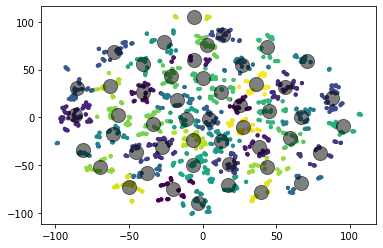

In [116]:
# clustering for modelNum
kmeans_cluster_plot(modelNum, 50)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



['for', 'office', 'site', 'over', 'temporary', 'handing', 'tightness', 'fm', 'development', 'appointment', 'contractor', 'on', 'issuance', 'monitoring', 'instrumentation', 'geotechnical', 'dc', 'progress', 'etc', 'clq', 'company', 'customer', 'consultant', 'shed', 'model', 'working', 'settlement', 'consulting', 'required']
['building', 'light', 'escalator', 'material', 'fat', 'partition', 'special', 'roadwork', 'mansory', 'siphonic', 'common', 'surface', 'plumb', 'turf', 'rubber', 'hand', 'artificial', 'laminate', 'functionality', 'programme', 'assembly', 'energy', 'shaft', 'vertical', 'pv', 'internal', 'fighting', 'line', 'installer', 'master', 'communication', 'alu', 'hospitality', 'steelwork', 'alarm', 'rated', 'checking', 'machinery', 'key', 'low', 'tool']
['ll', 'lggf', 'bb', 'rw', 'retaining', 'blg', 'gfl', 'mr', 'gfm', 'lr']
['installation', 'brickwork', 'panel', 'fw', 'glass', 'fabrication', 'perforated', 'subframe', 'pp', 'fan', 'louver', 'phase', 'cladding', 'ahu', 'fcu', 'sl

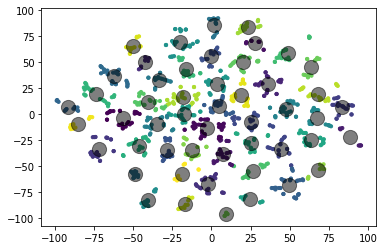

In [117]:
# clustering for modelAlp
kmeans_cluster_plot(modelAlp, 50)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



['area', 'test', 'piling', 'mock_up', 'plan', 'up', 'office', 'm2_facade', 'core', 'ready', 'land', 'relocation_of_waterpipe', 'review_comment', 'waterpipe', 'pmu', 'm2_pantry', 'm2_toilet', 'mobilisation', 'comment', 'site_clearing', 'relocation_of_tnb', 'land_p19', 'shopdrawings_structure', 'finalize_mock', 'vmu_mock', 'sp', 'performance', 'soil_investigation', 'car_park', 'toilet_mock', 'm2_disable', 'up_review', 'mapping', 'm2_janitor', 'm1_podium', 'up_finalize', 'pmu_mock', 'vmu_visual', 'walkway', 'extension', 'pmu_prototype', 'traffic_management', 'piloting', 'finalize']
['2nd', 'conduit', 'fire_protection', 'sanitary_plumbing', 'water_plumbing', 'electrical_pa', 'smatv', 'main', 'coat', 'cold_hot', 'sys', 'the', 'bcs', 'painting', 'elv', 'door', 'bm', 'floor_screed', 'ceiling_finish', 'ceiling', 'plastering_skim', 'window_dressing', 'loose_furniture', 'conceal_me', 'drywall_w', 'residential_villa', 'cjw', 'floor_tiling', 'office_chair', 'painting_base', 'painting_final', 'l1',

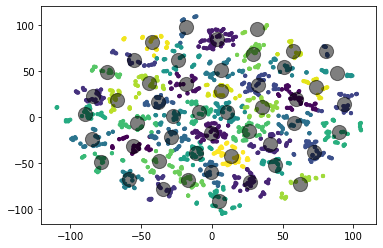

In [118]:
# clustering for modelNum_phrases
kmeans_cluster_plot(modelNum_phrases, 50)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



['completion', 'commencement', 'facade', 'for', 'steel_structure', 'building', 'structure', 'glass', 'roof_truss', 'lighting', 'architecture', 'fabrication', 'roofing', 'substructure', 'space', 'commencement_of_architecture', 'cm', 'completion_of_superstructure', 'sub', 'physical_completion', 'superstructure', 'wt', 'cp_fc', 'cp_tw', 'cm_tw', 'cm_fc', 'executive_leadership', 'team_elt', 'leadership_innovation', 'senior_leadership', 'jack_roof']
['ironmongery', 'floor_screed', 'brickwall', 'window_dressing', 'loose_furniture', 'drywall_w', 'conceal_me', 'cjw', 'office_chair', 'plaster_ceiling', 'ceiling_tee', 'broadloom', 'built_in_furniture', 'covering']
['tnb', 'osd', 'pilecap_stump', 'rwh_t', 'cable_containment', 'stressing', 'access_micropile', 'micropile_no', 'base', 'mpsj', 'bondeck', 'trenching', 'wbb_pedestrian', 'infrastructure_electric', 'infrastructure_telekom', 'cast_in_situ', 'pbt', 'leancon_anti', 'termite', 'placing_boom', 'spunpile_no', 'micropile', 'landscape_shrub', 'e

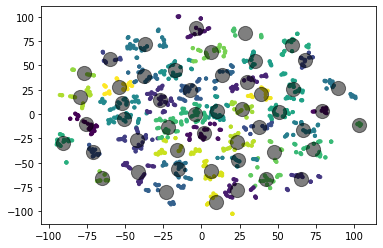

In [119]:
# clustering for modelAlp_phrases
kmeans_cluster_plot(modelAlp_phrases, 50)

# 5. Evaluation Prototype – Effectiveness of classifying activity words

In [132]:
# function for producing evaluation score
def evaluation(model):
    correct_activity = 0
    incorrect_activity = 0
    count = 0

    for word in base_activity_words:
        similar_words=model.wv.most_similar (positive=word, topn=5)
        print(word)
        print(model.wv.most_similar (positive=word, topn=5),'\n')
        for activity in activity_words[base_activity_words.index(word)]:
            if any(activity in x for x in similar_words): 
                correct_activity += model.wv.similarity(word, activity)
                count += 1
    average = correct_activity / count
    classification_index = correct_activity / 50
    print("Sum of cosine similarity for", count, "words :", correct_activity)
    print("Average cosine similarity :", correct_activity / count)
    print("Dividing by 50 words:",classification_index)
    
def list_activity_words():
    activity_word_list = []
    for x in range(10):
        for simword in activity_words[x]:
            activity_word_list.append(simword)
    print("Identified Activity words list")
    print(activity_word_list)
#for word in base_activity_words:
#        print(word)
#        print(modelAlp.wv.most_similar (positive=word, topn=5),'\n')

## K-means cluster variation in score
K-means cluster will change everytime it trains. Thus the activity words present will also change. Should use a specific seed or save the cluster to keep it constant.

In [133]:
# ModelNum evaluation
base_activity_words = ["casting", "drawing", "plastering", "proofing", "tiling", "widening", "installation", "laying", "cabling", "coating"]
activity_words = [['formwork', 'excavation', 'cutting'], ['lining','planning'],['painting'],[],['framing'],['paving','wearing'],['sliding'],[],['wiring'],[]]

evaluation(modelNum)
list_activity_words()


casting
[('rebar', 0.9558788537979126), ('formwork', 0.9244277477264404), ('leancon', 0.7903139591217041), ('cutting', 0.6782444715499878), ('jz02', 0.6689414381980896)] 

drawing
[('bq', 0.675261378288269), ('receival', 0.6669419407844543), ('issuance', 0.6469725370407104), ('concept', 0.6380796432495117), ('planning', 0.6326120495796204)] 

plastering
[('brickwall', 0.7484825849533081), ('painting', 0.6594752073287964), ('leaf', 0.6415979862213135), ('sks', 0.6299735307693481), ('sk', 0.6121896505355835)] 

proofing
[('grass', 0.8617507815361023), ('paver', 0.852872908115387), ('planter', 0.8250404000282288), ('topping', 0.8106581568717957), ('landscape', 0.7935457825660706)] 

tiling
[('screed', 0.7849946618080139), ('vinyl', 0.7559224367141724), ('vynil', 0.6813181638717651), ('laminate', 0.6539818048477173), ('operable', 0.6505714058876038)] 

widening
[('premix', 0.9630236029624939), ('paving', 0.902462363243103), ('binder', 0.8939948678016663), ('resurface', 0.885101318359375), 

In [122]:
base_activity_words = ["casting", "drawing", "plastering", "proofing", "tiling", "widening", "installation", "laying", "cabling", "coating"]
activity_words = [['formwork'], ['lining'],['painting'],['turfing'],['laminate'],['paving','transplanting'],[],[],[],[]]

evaluation(modelAlp)
list_activity_words()

casting
[('rebar', 0.9354692697525024), ('formwork', 0.9109682440757751), ('leancon', 0.7806012630462646), ('alpa', 0.6911320686340332), ('second', 0.6800203323364258)] 

drawing
[('concept', 0.6235676407814026), ('lake', 0.619538426399231), ('receival', 0.6194748282432556), ('bq', 0.6143479943275452), ('planning', 0.6096174120903015)] 

plastering
[('sk', 0.7638511061668396), ('sks', 0.722281813621521), ('brickwall', 0.7069738507270813), ('skw', 0.6699934005737305), ('brickwork', 0.6672559976577759)] 

proofing
[('grass', 0.8594626188278198), ('paver', 0.8451108932495117), ('shrub', 0.8243200182914734), ('turfing', 0.8147050738334656), ('grey', 0.7979413270950317)] 

tiling
[('vinyl', 0.7292210459709167), ('screed', 0.7181464433670044), ('laminate', 0.7058741450309753), ('operable', 0.6829472184181213), ('expoxy', 0.6779907941818237)] 

widening
[('premix', 0.9637225270271301), ('pjc', 0.914410412311554), ('paving', 0.9121665358543396), ('shrub', 0.8982859253883362), ('pond', 0.897222

In [123]:
# modelNum_phrases evaluation
# proofing changed to "water_proofing" as it was detected as a phrase and its original vocabulary deleted
base_activity_words = ["casting", "drawing", "plastering", "water_proofing", "tiling", "widening", "installation", "laying", "cabling", "coating"]
activity_words = [['formwork','soil_leveling', 'casting_second'], ['concrete_topping','issuance_of_construction'],['waterproofing','ironmongery'],['concrete_topping'],['framing'],['paving'],[],[],['structured_cabling'],['marking']]

evaluation(modelNum_phrases)
list_activity_words()

casting
[('rebar', 0.9723542332649231), ('formwork', 0.9596586227416992), ('leancon', 0.7816104292869568), ('soil_leveling', 0.7705475091934204), ('rc', 0.7233763337135315)] 

drawing
[('issuance_of_construction', 0.9139048457145691), ('ccc', 0.8778809905052185), ('package_ccc', 0.87110835313797), ('design', 0.8694519400596619), ('concrete_topping', 0.8618679642677307)] 

plastering
[('brickwall', 0.912100613117218), ('door_frame', 0.9019978642463684), ('door_leaf', 0.8636013269424438), ('waterproofing', 0.8225889205932617), ('ironmongery', 0.8138819336891174)] 

water_proofing
[('concrete_topping', 0.9632411003112793), ('landscape_grass', 0.9381338953971863), ('paver', 0.9355272650718689), ('wash', 0.9181848764419556), ('soil', 0.9074487090110779)] 

tiling
[('timber', 0.8573750257492065), ('operable', 0.847227931022644), ('metal', 0.839884340763092), ('cladding', 0.8378968238830566), ('window_subframe', 0.8282980918884277)] 

widening
[('premix', 0.9521071314811707), ('jalan', 0.9486

In [124]:
# modelAlp_phrases evaluation
base_activity_words = ["casting", "drawing", "plastering", "proofing", "tiling", "widening", "installation", "laying", "cabling", "coating"]
activity_words = [['formwork', 'pile_cutting'], ['issuance_of_construction'],['waterproofing', 'skim_coat','floor_screed'],['concrete_topping'],['coating'],['paving','lay'],[],[],['structured_cabling'],['covering']]

evaluation(modelAlp_phrases)
list_activity_words()

casting
[('formwork', 0.9836291670799255), ('rebar', 0.9707179665565491), ('leancon_k', 0.8179424405097961), ('pile_cutting', 0.8142496347427368), ('excavation_k', 0.8065453171730042)] 

drawing
[('shop', 0.9622508883476257), ('wms', 0.9198073744773865), ('concept', 0.8634312152862549), ('do_sub', 0.8552459478378296), ('issuance_of_construction', 0.8483728170394897)] 

plastering
[('waterproofing', 0.8154248595237732), ('brickwall', 0.793104887008667), ('epoxy', 0.7232074737548828), ('floor_screed', 0.7215465307235718), ('timber', 0.712300181388855)] 

proofing
[('ex_wr', 0.8702520728111267), ('recticulation', 0.8470127582550049), ('concrete_topping', 0.8295561671257019), ('food', 0.8172070980072021), ('grey', 0.8169824481010437)] 

tiling
[('ex_expoxy', 0.802840530872345), ('coating', 0.7929138541221619), ('vinyl', 0.7736549973487854), ('operable', 0.7637189030647278), ('epoxy', 0.7611708641052246)] 

widening
[('paving', 0.9482486844062805), ('jalan', 0.9465083479881287), ('premix', 

In [125]:
# modelNum_fasttext evaluation
# has a lot of words that may not be an activity
# careful of words like scaffolding, handrailing, railing, swimming, crossing, consulting, footing, ticketing, shopdrawing
# typos? plumbling
base_activity_words = ["casting", "drawing", "plastering", "proofing", "tiling", "widening", "installation", "laying", "cabling", "coating"]
activity_words = [['cutting'], ['planning'],['covering','painting'],['roofing','waterproofing','ponding','turfing'],['nailing', 'screeding'],['opening','lining, paving, planning, cleaning'],[],['mapping', 'probing', 'fencing', 'paving'],['plumbling', 'nailing', 'wiring'],['consulting','painting','paving']]

evaluation(modelNum_fasttext)
list_activity_words()

casting
[('rebar', 0.9322158098220825), ('formwork', 0.8941047787666321), ('leancon', 0.7750380635261536), ('cutting', 0.7056400775909424), ('cast', 0.6731491088867188)] 

drawing
[('shopdrawing', 0.8543161153793335), ('shopdrawings', 0.744482159614563), ('receival', 0.6747691035270691), ('planning', 0.6725946664810181), ('layout', 0.6626372337341309)] 

plastering
[('plaster', 0.8199269771575928), ('brickwall', 0.7557573914527893), ('covering', 0.7157319188117981), ('painting', 0.7047424912452698), ('sk', 0.6853569746017456)] 

proofing
[('roofing', 0.943440318107605), ('waterproofing', 0.9075213074684143), ('ponding', 0.8525291681289673), ('turfing', 0.7981100678443909), ('paving', 0.7373480200767517)] 

tiling
[('nailing', 0.8569726943969727), ('screeding', 0.7952002286911011), ('handrailing', 0.7855880856513977), ('railing', 0.7809339165687561), ('swimming', 0.7670155763626099)] 

widening
[('opening', 0.9543356895446777), ('paving', 0.9322708249092102), ('planning', 0.912167727947

In [126]:
# modelAlp_fasttext evaluation
# proofing has high similarity to roofing and waterproofing
# careful of words like anticlimbing
# unsure for piloting
base_activity_words = ["casting", "drawing", "plastering", "proofing", "tiling", "widening", "installation", "laying", "cabling", "coating"]
activity_words = [['formwork','backfilling','cutting'], ['planning'],['painting'],['roofing','waterproofing','turfing','ponding'],['nailing, piling'],['opening', 'planning', 'paving', 'lining', 'signing'],['integration'],['placing','fencing','mapping'],['plumbling','nailing','wiring'],['consulting','piloting','framing','painting']]

evaluation(modelAlp_fasttext)
list_activity_words()

casting
[('rebar', 0.9198870062828064), ('formwork', 0.879676342010498), ('leancon', 0.7387183904647827), ('curing', 0.7065353393554688), ('cutting', 0.7051336765289307)] 

drawing
[('shopdrawing', 0.8393009305000305), ('shopdrawings', 0.7226517796516418), ('earthing', 0.6644740700721741), ('planning', 0.662316083908081), ('wms', 0.6300087571144104)] 

plastering
[('plaster', 0.8090575933456421), ('sk', 0.7773513793945312), ('sks', 0.7450971603393555), ('painting', 0.7375814318656921), ('covering', 0.7308944463729858)] 

proofing
[('roofing', 0.9592648148536682), ('waterproofing', 0.9234569072723389), ('turfing', 0.8587671518325806), ('ponding', 0.852406919002533), ('topping', 0.7798281908035278)] 

tiling
[('nailing', 0.8834158182144165), ('railing', 0.8084051609039307), ('handrailing', 0.7976142168045044), ('piling', 0.7658016085624695), ('ceiling', 0.7579523324966431)] 

widening
[('opening', 0.9616304039955139), ('planning', 0.9261077046394348), ('paving', 0.9127603769302368), ('li